In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
data = pd.read_csv('data/telcom_users_steam.csv')
data.shape

(7081, 9)

In [73]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [74]:
# 独热编码
data = pd.get_dummies(data)
data.head(5)

,is_increase,age,Education_Level,consume,App,Gender_F,Gender_M,Cellphone_Android,Cellphone_iPhone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Level_Blue,Level_Gold,Level_Platinum,Level_Silver
0,0,2,1,32,5,0,1,0,1,0,1,0,1,0,0,0
1,0,2,2,31,6,1,0,0,1,0,0,1,1,0,0,0
2,0,1,2,33,4,0,1,0,1,0,1,0,1,0,0,0
3,0,3,1,32,5,0,1,0,1,0,1,0,1,0,0,0
4,0,2,2,32,3,0,1,1,0,0,1,0,1,0,0,0


In [75]:
#去除标签，并转换一下数据格式
# 数据与标签
import numpy as np
# 标签
labels = np.array(data['is_increase'])
# 在特征中去掉标签
features= data.drop('is_increase', axis = 1)
# 名字单独保存一下，以备后患
feature_list = list(features.columns)

In [76]:
# 数据集切分
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25,
                                                                           random_state = 42)

In [77]:
oversampler=SMOTE(random_state=0)


In [78]:
train_features,train_labels=oversampler.fit_resample(train_features,train_labels)

In [79]:
print('训练集特征:', train_features.shape)
print('训练集标签:', train_labels.shape)
print('测试集特征:', test_features.shape)
print('测试集标签:', test_labels.shape)

训练集特征: (8936, 15)
训练集标签: (8936,)
测试集特征: (1771, 15)
测试集标签: (1771,)


In [80]:
test_labels.sum()



271

In [81]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state =42)
classifier.fit(train_features, train_labels)

RandomForestClassifier(criterion='entropy', n_estimators=1000, random_state=42)

In [82]:
y_pred = classifier.predict(test_features)

In [83]:
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(test_labels, y_pred)

In [84]:
cm1

array([[1050,  450],
       [ 171,  100]], dtype=int64)

In [85]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    绘制混淆矩阵
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

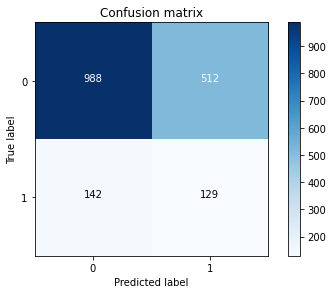

In [86]:
# 绘制
import itertools
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cm , classes=class_names
                      , title='Confusion matrix')
plt.show()

In [87]:
"""
随机森林分类Iris使用贝叶斯优化调参
"""
import numpy as np
from hyperopt import hp, tpe, Trials, STATUS_OK, Trials, anneal
from functools import partial
from hyperopt.fmin import fmin
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier

def model_metrics(model, x, y):
    """ 评估指标 """
    yhat = model.predict(x)
    return  f1_score(y, yhat,average='micro')

def bayes_fmin(train_x, test_x, train_y, test_y, eval_iters=50):
    """
    bayes优化超参数
    eval_iters：迭代次数
    """
    def factory(params):
        """
        定义优化的目标函数
        """
        fit_params = {
            'max_depth':int(params['max_depth']),
            'n_estimators':int(params['n_estimators']),
            'max_leaf_nodes': int(params['max_leaf_nodes'])
            }
        # 选择模型
        model = RandomForestClassifier(**fit_params)
        
        model.fit(train_x, train_y)
        # 最小化测试集（- f1score）为目标
        train_metric = model_metrics(model, train_x, train_y)
        test_metric = model_metrics(model, test_x, test_y)
        loss = - test_metric
        return {"loss": loss, "status":STATUS_OK}

    # 参数空间
    space = {
        'max_depth': hp.quniform('max_depth', 1, 120, 1),
        'n_estimators': hp.quniform('n_estimators', 2,150, 1), 
        'max_leaf_nodes': hp.quniform('max_leaf_nodes', 2, 100, 1)
            }
    # bayes优化搜索参数
    best_params = fmin(factory, space, algo=partial(anneal.suggest,), max_evals=eval_iters, trials=Trials(),return_argmin=True)
    # 参数转为整型
    best_params["max_depth"] = int(best_params["max_depth"])
    best_params["max_leaf_nodes"] = int(best_params["max_leaf_nodes"])
    best_params["n_estimators"] = int(best_params["n_estimators"])
    return best_params

#  搜索最优参数  train_features, test_features, train_labels, test_labels
#best_params = bayes_fmin(train_x, test_x, train_y, test_y, 100)
best_params = bayes_fmin(train_features, test_features, train_labels, test_labels, 100)
print(best_params)

100%|█████████████████████████████████████████████| 100/100 [00:12<00:00,  7.76trial/s, best loss: -0.6747600225861096]
{'max_depth': 15, 'max_leaf_nodes': 49, 'n_estimators': 20}


In [88]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 136, criterion = 'entropy',max_depth =3,max_leaf_nodes=2,random_state =42)
classifier.fit(train_features, train_labels)
y_pred = classifier.predict(test_features)
# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred)

In [89]:
cm



array([[988, 512],
       [142, 129]], dtype=int64)

In [90]:
array([[984, 516],
       [142, 129]], dtype=int64)    

array([[1050,  450],
       [ 171,  100]], dtype=int64)

NameError: name 'array' is not defined

In [91]:

array([[988, 512],
       [142, 129]], dtype=int64)

NameError: name 'array' is not defined

In [92]:
#精度
accurracy = (cm[0, 0] + cm[1, 1]) / (cm[0, 0] + cm[0, 1] + cm[1, 0] + cm[1, 1])
print(accurracy)
# 召回率
recall = cm[0, 0] / (cm[1, 0] + cm[0, 0])
print(recall)
# F1得分
F1_score = 2*accurracy*recall/(accurracy+recall)
print(F1_score)

specificity =  cm[1, 1] / (cm[1, 1] + cm[1, 0])
print(specificity)

0.6307171089779785
0.8743362831858407
0.7328096872532751
0.47601476014760147


In [64]:
array([[1050,  450],
       [ 171,  100]], dtype=int64)

NameError: name 'array' is not defined

In [93]:
#精度
accurracy = (cm1[0, 0] + cm1[1, 1]) / (cm1[0, 0] + cm1[0, 1] + cm1[1, 0] + cm1[1, 1])
print(accurracy)
# 召回率
recall = cm1[0, 0] / (cm1[1, 0] + cm1[0, 0])
print(recall)
# F1得分
F1_score = 2*accurracy*recall/(accurracy+recall)
print(F1_score)
specificity =  cm1[1, 1] / (cm1[1, 1] + cm1[1, 0])
print(specificity)

0.6493506493506493
0.85995085995086
0.7399577167019028
0.36900369003690037
